In [ ]:
# Import packages

In [28]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from glob2 import glob
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from ipywidgets import interactive
from collections import defaultdict
import hdbscan

In [ ]:
# Import and transform dataset

In [29]:
data_folder = 'C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data'

In [30]:
for f in glob(data_folder+"/*.csv"):
    print(f)

C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC London 2018.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC London 2019.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC London 2020.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC Los Angeles 2017.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC Los Angeles 2018.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC Los Angeles 2019.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC Los Angeles 2020.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC San Francisco 2017.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC San Francisco 2018.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC San Francisco 2019.csv
C:/Users/Anna/Documents/GitHub/citizen_science_inaturalist/data\CNC San Francisco 2020.csv


In [31]:
result = pd.concat([pd.read_csv(f).assign(challenge=f.replace(".csv","")) for f in glob(data_folder+"\*.csv")])

C:\Users\Anna\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [32]:
new_challenge = result.challenge.str.split('/', expand=True)
new_challenge

,0,1,2,3,4,5,6
0,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC London 2018
1,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC London 2018
2,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC London 2018
3,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC London 2018
4,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC London 2018
...,...,...,...,...,...,...,...
31794,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC San Francisco 2020
31795,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC San Francisco 2020
31796,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC San Francisco 2020
31797,C:,Users,Anna,Documents,GitHub,citizen_science_inaturalist,data\CNC San Francisco 2020


In [33]:
new_challenge.rename(columns={5: 'data', 6: 'challenge'}, inplace=True)

In [34]:
result['challenge'] = new_challenge['challenge']

In [35]:
# how much data do we have for each challenge? 
challenge_by_num = result.groupby(['challenge']).count()['id']
challenge_by_num = challenge_by_num.to_frame()
challenge_by_num.head()

,id
challenge,
data\CNC London 2018,2624
data\CNC London 2019,5345
data\CNC London 2020,5761
data\CNC Los Angeles 2017,18169
data\CNC Los Angeles 2018,19357


In [36]:
challenge_by_num.reset_index(inplace=True)
challenge_by_num.head()

,challenge,id
0,data\CNC London 2018,2624
1,data\CNC London 2019,5345
2,data\CNC London 2020,5761
3,data\CNC Los Angeles 2017,18169
4,data\CNC Los Angeles 2018,19357


In [37]:
test_df = challenge_by_num.challenge.str.split(' ', expand=True)
test_df.head()

,0,1,2,3
0,data\CNC,London,2018,None
1,data\CNC,London,2019,None
2,data\CNC,London,2020,None
3,data\CNC,Los,Angeles,2017
4,data\CNC,Los,Angeles,2018


In [38]:
test_df[['city', 'year']] = challenge_by_num.challenge.str.split(' 20', expand=True)

In [39]:
challenge_by_num['city'] = test_df['city']
challenge_by_num['year'] = test_df['year']
challenge_by_num.rename(columns={"id": "num_data"}, inplace=True)
challenge_by_num.head()

,challenge,num_data,city,year
0,data\CNC London 2018,2624,data\CNC London,18
1,data\CNC London 2019,5345,data\CNC London,19
2,data\CNC London 2020,5761,data\CNC London,20
3,data\CNC Los Angeles 2017,18169,data\CNC Los Angeles,17
4,data\CNC Los Angeles 2018,19357,data\CNC Los Angeles,18


In [40]:
challenge_by_num[['cnc', 'city2']] = challenge_by_num.city.str.split('CNC ', expand=True)
challenge_by_num.drop(columns=['city', 'cnc', 'challenge'], inplace=True)
challenge_by_num.head()

,num_data,year,city2
0,2624,18,London
1,5345,19,London
2,5761,20,London
3,18169,17,Los Angeles
4,19357,18,Los Angeles


In [41]:
challenge_by_num.year = pd.to_numeric(challenge_by_num.year)
challenge_by_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   num_data  11 non-null     int64 
 1   year      11 non-null     int64 
 2   city2     11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


In [42]:
result[['city', 'year']] = result.challenge.str.split(' 20', expand=True)

In [43]:
result[['cnc', 'city2']] = result.city.str.split('CNC ', expand=True)

In [44]:
result.drop(columns=['city', 'cnc'], inplace=True)
result.rename(columns={"city2": "challenge_city", 'year':'challenge_year'}, inplace=True)

In [45]:
LD_challenge = result[result.challenge_city == 'London']

In [46]:
LD_challenge_18 = LD_challenge[LD_challenge.challenge_year == '18']
LD_challenge_19 = LD_challenge[LD_challenge.challenge_year == '19']
LD_challenge_20 = LD_challenge[LD_challenge.challenge_year == '20']

In [47]:
LD_challenge_19.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,created_at,updated_at,quality_grade,...,positioning_method,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id,challenge,challenge_year,challenge_city
0,22277087,2019-04-28 12:01:16 pm BST,2019-04-28,2019-04-28 12:01:16 UTC,UTC,1595601,louisaroscoe,2019-04-10 11:05:41 UTC,2019-04-28 16:53:29 UTC,research,...,NaN,NaN,common dandelion,Taraxacum officinale,common dandelion,Plantae,47602.0,data\CNC London 2019,19,London
1,22364809,2019-04-28 12:09:02 pm BST,2019-04-28,2019-04-28 12:09:02 UTC,UTC,1595601,louisaroscoe,2019-04-12 11:52:54 UTC,2019-04-28 16:53:02 UTC,casual,...,NaN,NaN,Cowslip,Primula veris,Cowslip,Plantae,55819.0,data\CNC London 2019,19,London
2,22605691,2019-04-28 3:02:10 pm BST,2019-04-28,2019-04-28 15:02:10 UTC,UTC,1595601,louisaroscoe,2019-04-17 14:02:21 UTC,2019-11-30 15:44:44 UTC,research,...,NaN,NaN,Nèpe,Nepa cinerea,Water Scorpion,Insecta,133020.0,data\CNC London 2019,19,London
3,22606216,2019-04-28,2019-04-28,NaN,UTC,1595601,louisaroscoe,2019-04-17 14:15:59 UTC,2019-05-14 07:05:10 UTC,needs_id,...,gps,gps,mayfly nymph,Ephemeroptera,Mayflies,Insecta,48011.0,data\CNC London 2019,19,London
4,22933191,2019-04-28,2019-04-28,NaN,UTC,1595601,louisaroscoe,2019-04-23 09:16:15 UTC,2019-05-14 07:14:41 UTC,needs_id,...,gps,gps,Ramshorn snails,Planorbidae,Ramshorn snails,Mollusca,85990.0,data\CNC London 2019,19,London


In [ ]:
# Clusters with DBSCAN 2018-2020

In [48]:
import plotly.express as px

In [ ]:
# London 2018

In [ ]:
# Determine epsilon

In [49]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(LD_challenge_18[["latitude","longitude"]])
distances, indices = nbrs.kneighbors(LD_challenge_18[["latitude","longitude"]])

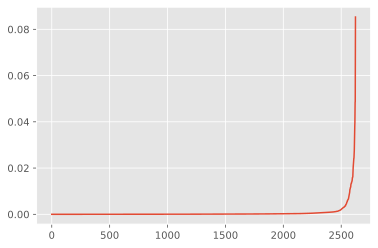

In [50]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
# choose epsilon of 0.01
# determine clusters

In [65]:
Z = LD_challenge_18[["latitude","longitude"]].to_numpy()
model = DBSCAN(eps=0.01, min_samples=50).fit(Z)
class_predictions = model.labels_
LD_challenge_18['CLUSTERS_DBSCAN'] = class_predictions
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')
print(f'Silhouette ignoring outliers: {silhouette_score(Z[class_predictions!=-1], class_predictions[class_predictions!=-1])}')
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(Z, no_outliers)}')

<ipython-input-65-443ef2e547c2>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of clusters found: 10
Number of outliers found: 618
Silhouette ignoring outliers: 0.8524002599788582
Silhouette outliers as singletons: 0.450508884420837


In [ ]:
# transform clusters to strings

In [66]:
LD_challenge_18["CLUSTERS_DBSCAN"] = LD_challenge_18["CLUSTERS_DBSCAN"].astype(str)

<ipython-input-66-6d2a876bc224>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# map clusters

In [67]:
fig = px.scatter_mapbox(LD_challenge_18, lat="latitude", lon="longitude", color="CLUSTERS_DBSCAN", size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

In [ ]:
# London 2019

In [ ]:
# Determine epsilon

In [54]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(LD_challenge_19[["latitude","longitude"]])
distances, indices = nbrs.kneighbors(LD_challenge_19[["latitude","longitude"]])

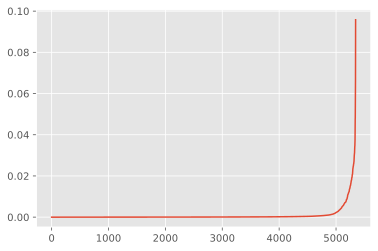

In [55]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
# choose epsilon of 0.01
# determine clusters

In [56]:
X = LD_challenge_19[["latitude","longitude"]].to_numpy()
model = DBSCAN(eps=0.01, min_samples=50).fit(X)
class_predictions = model.labels_
LD_challenge_19['CLUSTERS_DBSCAN'] = class_predictions
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')
print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

<ipython-input-56-51745aa82a57>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of clusters found: 20
Number of outliers found: 872
Silhouette ignoring outliers: 0.8148179113817863
Silhouette outliers as singletons: 0.47838511057060856


In [ ]:
# transform clusters to strings

In [57]:
LD_challenge_19["CLUSTERS_DBSCAN"] = LD_challenge_19["CLUSTERS_DBSCAN"].astype(str)

<ipython-input-57-76faf85b70dc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# map clusters

In [58]:
fig = px.scatter_mapbox(LD_challenge_19, lat="latitude", lon="longitude", color="CLUSTERS_DBSCAN", size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

In [ ]:
# London 2020

In [59]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(LD_challenge_20[["latitude","longitude"]])
distances, indices = nbrs.kneighbors(LD_challenge_20[["latitude","longitude"]])

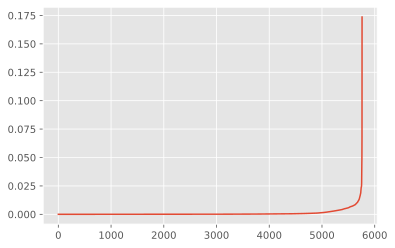

In [60]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [68]:
Y = LD_challenge_20[["latitude","longitude"]].to_numpy()
model = DBSCAN(eps=0.01, min_samples=50).fit(Y)
class_predictions = model.labels_
LD_challenge_20['CLUSTERS_DBSCAN'] = class_predictions
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')
print(f'Silhouette ignoring outliers: {silhouette_score(Y[class_predictions!=-1], class_predictions[class_predictions!=-1])}')
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(Y, no_outliers)}')


<ipython-input-68-cf231bdee440>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of clusters found: 24
Number of outliers found: 2436
Silhouette ignoring outliers: 0.8376675232213342
Silhouette outliers as singletons: 0.25450279369027473


In [69]:
LD_challenge_20["CLUSTERS_DBSCAN"] = LD_challenge_20["CLUSTERS_DBSCAN"].astype(str)

<ipython-input-69-884b0941ebd7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
fig = px.scatter_mapbox(LD_challenge_20, lat="latitude", lon="longitude", color="CLUSTERS_DBSCAN", size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()